In [0]:
!pip install --upgrade tables
!pip install eli5

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance

In [0]:
cd drive/My Drive/Colab Notebooks/Data-Workshop/Matrix_part_two/Data-Workshop-Cars/

[Errno 2] No such file or directory: 'drive/My Drive/Colab Notebooks/Data-Workshop/Matrix_part_two/Data-Workshop-Cars/'
/content/drive/My Drive/Colab Notebooks/Data-Workshop/Matrix_part_two/Data-Workshop-Cars


## wczytywanie danych


In [0]:
df = pd.read_hdf('data/car.h5')

In [0]:
df.shape

(106494, 155)

In [0]:
df.columns.values

array(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       'feature_kurtyny-powietrzne', 'feature_klimatyzacja-dwustrefowa',
       'feature_światła-led', 'feature_czujnik-zmierzchu',
       'feature_elektrycznie-ustawiane-lusterka',
       'feature_asr-(kontrola-trakcji)',
       'feature_poduszka-powietrzna-kierowcy', 'feature_cd',
       'feature_elektryczne-szyby-przednie',
       'feature_poduszka-powietrzna-pasażera',
       'feature_system-start-stop', 'feature_światła-do-jazdy-dziennej',
       'feature_komputer-pokładowy', 'feature_elektryczne-szyby-tylne',
       'feature_klimatyzacja-manualna', 'feature_tapicerka-welurowa',
       'feature_czujnik-deszczu', 'feature_światła-przeciwmgielne',
       'feature_ogrzewanie-postojowe', 'feature_radio-niefabryczne',
       'feature_regulowane-zaw

## Dummy model

In [0]:
feats = ['car_id']
X = df[feats].values
y = df['price_value'].values

model = DummyRegressor()

model.fit(X,y)
y_pred = model.predict(X)
mae(y, y_pred)

39465.934630440985

In [0]:
# zworcmy uwage ze jest rozna waluta. EUR to jedynie 0.19%
df['price_currency'].value_counts(), df['price_currency'].value_counts(normalize = True)*100

(PLN    106290
 EUR       204
 Name: price_currency, dtype: int64, PLN    99.80844
 EUR     0.19156
 Name: price_currency, dtype: float64)

In [0]:
# usuwamy eur z modelu
df = df[df['price_currency'] != 'EUR']

In [0]:
df['price_currency'].value_counts()

PLN    106290
Name: price_currency, dtype: int64

## Features

In [0]:
# Faktoryzujemy features
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue #sprawdza czy w srodku jest lista i kontynuuje, inaczej sie wykrzacza

  factorized_values = df[feat].factorize()[0] #jezeli juz istnieje, nadpisz
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:  
    df[feat + SUFFIX_CAT] = factorized_values

In [0]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x] # zapisujemy wszystkie zmienne ktore sfaktoryzowalismy w 1 tablicy
cat_feats = [x for x in cat_feats if 'price' not in x] # usuwamy ceny, bo je bedziemy prognozowac
len(cat_feats)

151

In [0]:
# trening
X = df[cat_feats].values
y = df['price_value'].values

model = DecisionTreeRegressor(max_depth=5)
scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
np.mean(scores)

-19566.588937368328

In [0]:
# eli oceni teraz wagi
m = DecisionTreeRegressor(max_depth=5)
m.fit(X,y)

imp = PermutationImportance(m, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2533 ± 0.0040,param_napęd__cat
0.2008 ± 0.0047,param_faktura-vat__cat
0.1943 ± 0.0088,param_stan__cat
0.1423 ± 0.0086,param_rok-produkcji__cat
0.0629 ± 0.0047,param_moc__cat
0.0424 ± 0.0014,feature_kamera-cofania__cat
0.0412 ± 0.0008,param_skrzynia-biegów__cat
0.0286 ± 0.0037,param_marka-pojazdu__cat
0.0191 ± 0.0022,param_pojemność-skokowa__cat
0.0163 ± 0.0005,feature_bluetooth__cat


In [0]:
# powzyszy kod zapiszmyjako funkcje gdzie mozemy badac rozne parametry/ficzery, podawać ile wartosci ma wyswietlac model itp

def group_and_plot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean, np.median, np.size], feat_sort='mean', top=20, subplots=True):
  return (
      df
      .groupby(feat_groupby)[feat_agg]
      .agg(agg_funcs)
      .sort_values(by=feat_sort, ascending=False)
      .head(top)

  ).plot(kind='bar', figsize=(15,5), subplots=subplots)



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9c0fbbbe0>,
      dtype=object)

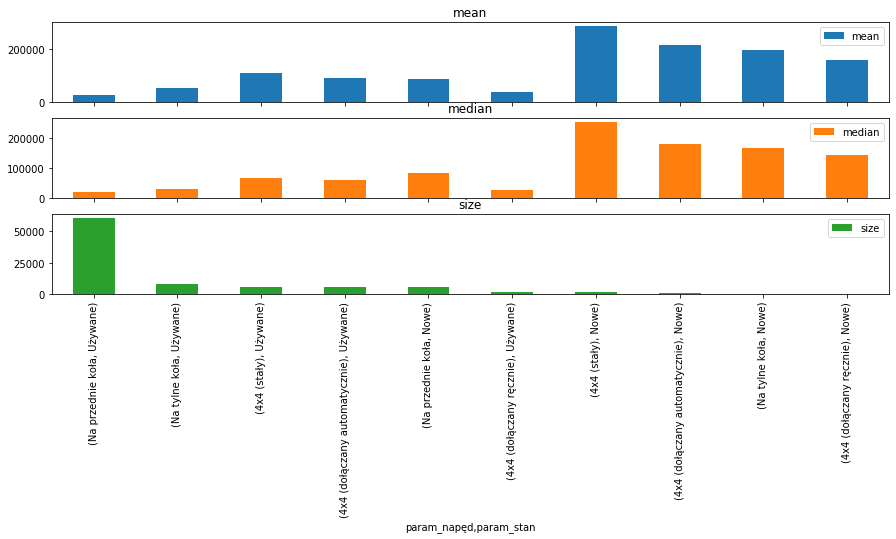

In [0]:
group_and_plot(['param_napęd','param_stan' ], feat_sort='size')

In [0]:
df['param_napęd'].value_counts(normalize = True)*100

Na przednie koła                 73.294273
Na tylne koła                     9.548957
4x4 (stały)                       7.721214
4x4 (dołączany automatycznie)     7.625602
4x4 (dołączany ręcznie)           1.809955
Name: param_napęd, dtype: float64